# Decentralized Consensus With Gradient Descent

## Background and Problem


Assume neighbor_allreduce and graph has already been discussed.

## Gradient Descent part --- Synthetic dataset + Logistic regression?


1. Adapt-With-Combine:

\begin{equation}
    x_i = A x_i - \alpha \nabla F(x_i)
\end{equation}


2. Adapt-With-Combine:

\begin{equation}
    x_i = A (x_i - \alpha \nabla F(x_i))
\end{equation}


Discuss the difference between the implementation and overlap of time between the computation and communication.


Three key functions to introduce:

- `neighbor_allreduce` -- already discussed
- `neighbor_allreduce_nonblocking`
- `wait`


Have a brief talk performance difference.


One example code based on manual gradient computation and another on torch auto-gradient computation.



Timeline within one worker (blocking):
```
---communication------|
                      |------computation------
```

Nonblocking case:

```
---communication------|
      ------computation------
```

Use  %timeit to show the difference

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import cvxpy as cvx
%matplotlib inline

In [2]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3]

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 2 among 4 processes
[stdout:1] Hello, I am 0 among 4 processes
[stdout:2] Hello, I am 1 among 4 processes
[stdout:3] Hello, I am 3 among 4 processes


In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

In [5]:
# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None]

In [6]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021


In [7]:
%%px

# Define Classifer class. Define Logistic Regression class based off of Classifier class.
class Classifier():
    def __init__(self, w_star):
        """
        Member Variables
        - w (torch tensor) := Parameter of size (dim , 1)
        - w_star (torch tensor) := Actual parameters of size (dim ,1)
        - c_client (float) := Control variate from the client.
        """
        self.w = None
        self.w_star = w_star
        self.c_client = None
    def obj(self, X, y, reg):
        """
        Compute the value of the loss function.
        Inputs:
        - X (torch tensor) := The data to calculate the loss on of size (N, dim).
        - y (torch tensor) := The corresponding labels of the data of size (N, 1).
        - reg (float) := The regularization parameter.
        Outputs:
        - obj (float) := Value of the objective function.
        """

    def grad(self, X_batch, y_batch, reg):
        """
        Compute the gradient.
        Inputs:
        - X_batch (torch tensor) := The data to calculate the gradient on of size (N, dim).
        - y_batch (torch tensor) := The corresponding labels of the data of size (N, 1).
        - reg (float) := The regularization parameter.
        Outputs:
        - grad (torch tensor) := Gradient with respect to self.w of size (dim, 1).
        """
    
    def AWC(self, X, y, step_size=0.75, reg=1e-4, batch_size=50):
        """
        Adapt with combine algorithm using blocking communication. Performs one iteration.
        Inputs:
        - X (torch tensor) := The data to calculate the loss on of size (N, dim).
        - y (torch tensor) := The corresponding labels of the data of size (N, 1).
        - reg (float) := The regularization parameter.
        - batch_size (int) := Size of a batch for the iteration.
        Output:
        - Relative error of all workers.
        """
        N, dim = X.shape
        if self.w is None:
            self.w = 0.001 * torch.randn((dim, 1))
        rand_idx = torch.randint(0, N-1, (batch_size, ))
        X_batch = X[rand_idx, :]
        y_batch = y[rand_idx]        
        self.w = self.w - step_size * self.grad(X_batch, y_batch, reg)
        self.w = bf.neighbor_allreduce(self.w, self_weight, neighbor_weights)
        dist = torch.norm(self.w - self.w_star, p=2)/torch.norm(self.w_star, p=2)
        averaged_relative_error = bf.allreduce(dist**2, average=True)
        return torch.sqrt(averaged_relative_error)
    
    def ATC(self, X, y, step_size=0.75, reg=1e-4, batch_size=50):
        """
        Adapt then combine algorithm using blocking communication. Performs one iteration.
        Inputs:
        - X (torch tensor) := The data to calculate the loss on of size (N, dim).
        - y (torch tensor) := The corresponding labels of the data of size (N, 1).
        - reg (float) := The regularization parameter.
        - batch_size (int) := Size of a batch for the iteration.
        Output:
        - Relative error of all workers.
        """
        N, dim = X.shape
        if self.w is None:
            self.w = 0.001 * torch.randn((dim, 1))
        rand_idx = torch.randint(0, N-1, (batch_size, ))
        X_batch = X[rand_idx, :]
        y_batch = y[rand_idx]
        Aw = bf.neighbor_allreduce(self.w, self_weight, neighbor_weights)
        adapt = step_size * self.grad(X_batch, y_batch, reg)
        self.w = Aw - adapt
        dist = torch.norm(self.w - self.w_star, p=2)/torch.norm(self.w_star, p=2)
        averaged_relative_error = bf.allreduce(dist**2, average=True)
        return torch.sqrt(averaged_relative_error)
    
    def ATC_nonblocking(self, X, y, step_size=0.75, reg=1e-4, batch_size=50):
        """
        Adapt then combine algorithm using non-blocking communication. Performs one iteration.
        Inputs:
        - X (torch tensor) := The data to calculate the loss on of size (N, dim).
        - y (torch tensor) := The corresponding labels of the data of size (N, 1).
        - reg (float) := The regularization parameter.
        - batch_size (int) := Size of a batch for the iteration.
        Output:
        - Relative error of all workers.
        """
        N, dim = X.shape
        if self.w is None:
            self.w = 0.001 * torch.randn((dim, 1))
        rand_idx = torch.randint(0, N-1, (batch_size, ))
        X_batch = X[rand_idx, :]
        y_batch = y[rand_idx]
        Aw = bf.neighbor_allreduce_nonblocking(self.w, self_weight, neighbor_weights)
        adapt = step_size * self.grad(X_batch, y_batch, reg)
        bf.wait(Aw)
        self.w = Aw - adapt
        dist = torch.norm(self.w - self.w_star, p=2)/torch.norm(self.w_star, p=2)
        averaged_relative_error = bf.allreduce(dist**2, average=True)
        return torch.sqrt(averaged_relative_error)
        
class LogReg(Classifier):
    def __init__(self, w_star):
        super(LogReg, self).__init__(w_star)
    
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))
    
    def obj(self, X, y, reg):
        N, _ = X.shape
        return 1/N * torch.sum(torch.log(1 + torch.exp(-y * X @ self.w))) + 1/2 * reg * self.w.T @ self.w 
    
    def grad(self, X_batch, y_batch, reg):
        N_batch, _ = X_batch.shape
        return 1/N_batch * X_batch.T @ (y_batch * (self.sigmoid(y_batch * X_batch @ self.w) - 1)) + reg * self.w

In [8]:
# Generate data and write auxilary functions.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
"""
Global Parameters:
    N (int) := Number of data points.
    dim (int) := Dimension of a data point.
    reg (float) := Regularization parameter.
    w (np.array) := Parameters of size (dim, 1).
    X (np.array) := Data of size (N, dim).
    y (np.array) := Labels of data of size (dim, 1).
    ss (float) := Step-size.
    ep (int) := Number of epochs in between a round of communication.
    batch (int) := Batch size.
    exp (int) := Number of experiments.
    comms (int) := Number of communications.
    num_workers (int) := Number of workers.
"""
N = 8000
dim = 10
reg = 1e-4
np.random.seed(0)

w = np.random.multivariate_normal([0.0]*dim, np.eye(dim), 1).T
X = np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N)
X = normalize(X, axis = 1, norm = 'l2')
y = 2 * (np.random.uniform(size = (N, 1)) < sigmoid(X @ w)) - 1
ss = 0.1
ep = 1
batch = 50
exp = 5
comms = 100
num_workers = len(rc.ids)

In [9]:
# Solve using CVX to find the optimal solution.
w_star = cvx.Variable((dim, 1))
loss = 1/N * cvx.sum(cvx.logistic(-cvx.multiply(y, X @ w_star))) + reg/2 * cvx.sum_squares(w_star)
problem = cvx.Problem(cvx.Minimize(loss))
problem.solve(verbose = False, abstol = 1e-15)
opt = problem.value
print(f'Optimal objective function value is: {opt}')

Optimal objective function value is: 0.558468913332832


In [10]:
# Convert numpy arrays to PyTorch tensor.
w_star_tensor = torch.from_numpy(w_star.value)
X_tensor = torch.Tensor(X).to(torch.float32)
y_tensor = torch.Tensor(y).to(torch.float32)

In [11]:
dview.push({'w_star_tensor': w_star_tensor, 'X_tensor' : X_tensor, 'y_tensor' : y_tensor})

[None, None, None, None]

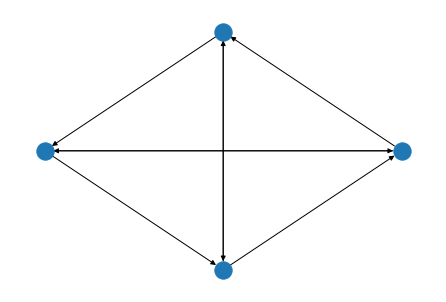

In [12]:
# Generate topology.

# Plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [13]:
%%px

# Set topology as exponential-2 graph.
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

In [14]:
%%px
# Scale weights

if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)
        
self_weight = (self_weight+1)/2
for k, v in neighbor_weights.items():
    neighbor_weights[k] = v/2
    
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:1] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333
self weights: 0.6666666666666666

neighbor weights:
2 0.16666666666666666
3 0.16666666666666666


In [15]:
%%px
# Adapt with combine. Using blocking communication.



maxite = 2500
batch_size, _ = X_tensor.shape
solver = LogReg(w_star_tensor)
relative_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%100 == 0:
            print('Progress {}/{}'.format(ite, maxite))
    
    relative_error[ite] = solver.AWC(X_tensor, y_tensor, batch_size=batch_size)

[stdout:1] 
Progress 0/2500
Progress 100/2500
Progress 200/2500
Progress 300/2500
Progress 400/2500
Progress 500/2500
Progress 600/2500
Progress 700/2500
Progress 800/2500
Progress 900/2500
Progress 1000/2500
Progress 1100/2500
Progress 1200/2500
Progress 1300/2500
Progress 1400/2500
Progress 1500/2500
Progress 1600/2500
Progress 1700/2500
Progress 1800/2500
Progress 1900/2500
Progress 2000/2500
Progress 2100/2500
Progress 2200/2500
Progress 2300/2500
Progress 2400/2500


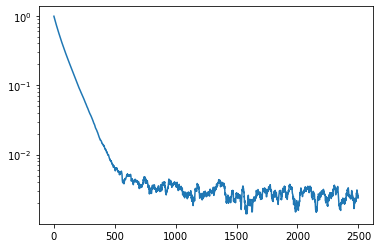

In [16]:
relative_error = dview.pull('relative_error', block=True, targets=0)
plt.semilogy(relative_error)

In [17]:
%%px
# Adapt then combine. Using blocking communication.

maxite = 2500
batch_size, _ = X_tensor.shape
solver_1 = LogReg(w_star_tensor)
relative_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%100 == 0:
            print('Progress {}/{}'.format(ite, maxite))
    
    relative_error[ite] = solver_1.ATC(X_tensor, y_tensor, batch_size=batch_size)

[stdout:1] 
Progress 0/2500
Progress 100/2500
Progress 200/2500
Progress 300/2500
Progress 400/2500
Progress 500/2500
Progress 600/2500
Progress 700/2500
Progress 800/2500
Progress 900/2500
Progress 1000/2500
Progress 1100/2500
Progress 1200/2500
Progress 1300/2500
Progress 1400/2500
Progress 1500/2500
Progress 1600/2500
Progress 1700/2500
Progress 1800/2500
Progress 1900/2500
Progress 2000/2500
Progress 2100/2500
Progress 2200/2500
Progress 2300/2500
Progress 2400/2500


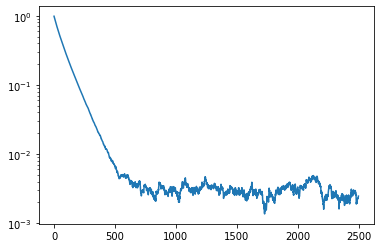

In [18]:
relative_error = dview.pull('relative_error', block=True, targets=0)
plt.semilogy(relative_error)

In [19]:
%%px
# Adapt then combine. Using non-blocking communication.

maxite = 2500
batch_size, _ = X_tensor.shape
solver_2 = LogReg(w_star_tensor)
relative_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%100 == 0:
            print('Progress {}/{}'.format(ite, maxite))
    
    relative_error[ite] = solver_2.ATC_nonblocking(X_tensor, y_tensor, batch_size=batch_size)

[stdout:1] 
Progress 0/2500
Progress 100/2500
Progress 200/2500
Progress 300/2500
Progress 400/2500
Progress 500/2500
Progress 600/2500
Progress 700/2500
Progress 800/2500
Progress 900/2500
Progress 1000/2500
Progress 1100/2500
Progress 1200/2500
Progress 1300/2500
Progress 1400/2500
Progress 1500/2500
Progress 1600/2500
Progress 1700/2500
Progress 1800/2500
Progress 1900/2500
Progress 2000/2500
Progress 2100/2500
Progress 2200/2500
Progress 2300/2500
Progress 2400/2500


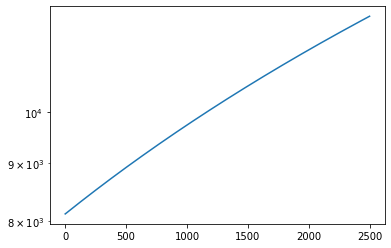

In [20]:
relative_error = dview.pull('relative_error', block=True, targets=0)
plt.semilogy(relative_error)

In [ ]:
# Overlapping pseudo code:
handle = bf.neighbor_allreduce_nonblocking(grad)
gradient_computation(x)
bf.wait(handle)

In [ ]:
# Overlapping pseudo code:
handle = bf.neighbor_allreduce(grad)
gradient_computation(x)

## Stochastic Gradient part -- Application : MNIST

Related with reading the dataset and plot the figures and visualized the weights.

Similar but more about the MSE metrics and irreducible error?

More focus on the theoratical part and choose different application.


